# UCI mHealth Classification - CNN-GRU
- https://archive.ics.uci.edu/dataset/319/mhealth+dataset

#### 데이터 구조
- 10명의 참가자별로 mHealth_subject<SUBJECT_ID>.log 파일 존재
- 가속도, 자이로, 자기장, 심전도 -> 총 23개의 feature

#### 라벨
0. Other
1. Standing still
2. Sitting and relaxing
3. Lying down
4. Walking
5. Climbing stairs
6. Waist bends forward
7. Frontal elevation of arms
8. Knees bending (crouching)
9. Cycling
10. Jogging
11. Running
12. Jump front & back


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import resample
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
base_dir = "/content/drive/MyDrive/AI_data/MHEALTHDATASET"
dfs = []
col_names = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg1', 'ecg2',
    'acc_left_ankle_x', 'acc_left_ankle_y', 'acc_left_ankle_z',
    'gyro_left_ankle_x', 'gyro_left_ankle_y', 'gyro_left_ankle_z',
    'magnet_left_ankle_x', 'magnet_left_ankl6e_y', 'magnet_left_ankle_z',
    'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z',
    'gyro_right_arm_x', 'gyro_right_arm_y', 'gyro_right_arm_z',
    'magnet_right_arm_x', 'magnet_right_arm_y', 'magnet_right_arm_z',
    'label', 'subject'
]

for i in range(1, 11):
    path = os.path.join(base_dir, f"mHealth_subject{i}.log")
    df_i = pd.read_csv(path, sep='\t', header=None)
    df_i['subject'] = i
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(how='any', axis=0)
df.columns = col_names
df

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z,label,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-4.5781,0.187760,-0.449020,-1.01030,0.034483,-2.35000,-1.610200,-0.030899,0,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.449020,-1.01030,0.034483,-2.16320,-0.882540,0.326570,0,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.449020,-1.01030,0.034483,-1.61750,-0.165620,-0.030693,0,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.456860,-1.00820,0.025862,-1.07710,0.006945,-0.382620,0,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.456860,-1.00820,0.025862,-0.53684,0.175900,-1.095500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-9.2476,-0.248070,-2.62230,0.230250,0.234430,1.7849,-9.8287,0.29725,-0.341370,-0.90056,...,-8.9071,0.294230,0.041176,-0.99384,-0.480600,2.40890,7.496100,7.915500,0,10
1215741,-9.4632,-0.073513,-2.11190,0.276300,0.284670,1.8687,-9.8766,0.46236,-0.341370,-0.90056,...,-8.7455,0.448140,0.041176,-0.99384,-0.480600,1.69450,7.866000,7.897500,0,10
1215742,-9.4011,-0.144580,-3.02350,0.288850,0.301410,1.6928,-9.9290,0.16631,-0.341370,-0.90056,...,-9.1155,0.450480,0.041176,-0.99384,-0.480600,1.15770,8.052800,7.884900,0,10
1215743,-9.3732,-0.026252,-2.70760,0.351650,0.347460,1.5279,-9.6306,0.30458,-0.341370,-0.90056,...,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0.27441,9.487900,5.325800,0,10


In [4]:
df.label.value_counts()

,count
label,
0,872550
1,30720
2,30720
3,30720
4,30720
9,30720
5,30720
11,30720
10,30720


In [5]:
# downsampling
from sklearn.utils import resample

df_majority = df[df.label==0]
df_minorities = df[df.label!=0]

df_majority_downsampled = resample(df_majority, n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.label.value_counts()

,count
label,
1,30720
3,30720
2,30720
4,30720
9,30720
11,30720
5,30720
10,30720
0,30000


In [6]:
# df.to_csv('/content/drive/MyDrive/AI_data/MHEALTHDATASET/mhealth_resampled_data.csv',index = False)

In [7]:
df.isnull().sum()

,0
acc_chest_x,0
acc_chest_y,0
acc_chest_z,0
ecg1,0
ecg2,0
acc_left_ankle_x,0
acc_left_ankle_y,0
acc_left_ankle_z,0
gyro_left_ankle_x,0
gyro_left_ankle_y,0


In [8]:
# 피험자 1-6: 훈련, 피험자 7-8: 검증, 피험자 8-9: 테스트
train = df[~df['subject'].isin([7, 8, 9, 10])]
val = df[df['subject'].isin([7, 8])]
test = df[df['subject'].isin([9, 10])]

train.shape, val.shape, test.shape

((226128, 25), (73326, 25), (73741, 25))

In [9]:
X_train = train.drop(['label','subject'], axis=1)
y_train = train['label']

X_val = val.drop(['label','subject'], axis=1)
y_val = val['label']

X_test = test.drop(['label','subject'], axis=1)
y_test = test['label']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((226128, 23), (226128,), (73326, 23), (73326,), (73741, 23), (73741,))

In [10]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(sc.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(sc.fit_transform(X_test), columns=X_train.columns)

X_train

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,magnet_left_ankle_z,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z
0,-0.087384,-0.180627,-0.786215,0.007915,-0.011472,-0.577582,0.733111,0.855263,0.283638,-0.578020,...,-0.402525,-0.878509,-0.115785,0.092842,-1.287582,0.881529,-0.227001,0.355856,-0.757309,0.065910
1,-0.328788,-0.300078,0.605666,-0.081073,-0.087624,-0.048897,-0.100417,0.083515,-0.577486,-0.415903,...,0.011245,0.142070,-0.403044,0.292032,-1.181228,-0.788334,-0.017597,-0.007098,-0.073927,-0.046895
2,0.241808,0.040644,-0.641235,0.070732,-0.107931,0.010368,0.093603,-0.501927,-0.867129,0.049140,...,0.540380,0.419364,-0.149160,-0.108985,-0.159630,-0.799296,-1.414959,-0.118250,-0.093139,-0.227639
3,-0.354832,-0.009466,0.177121,-0.447507,-1.224823,-0.497284,-0.085610,0.353416,-1.442512,-0.458564,...,-0.030661,0.347123,-0.554803,-0.268771,0.292298,-1.000270,-1.567971,0.008544,-0.094608,-0.020982
4,0.244441,0.152781,-0.843392,-0.332342,-0.184085,-1.151754,-0.146134,-0.361905,1.782740,0.484325,...,2.124397,-0.463871,-0.334905,-0.028403,-0.584985,-0.481392,0.522008,0.201140,0.141492,-0.024674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226123,-0.998367,0.135213,-0.547845,-0.248588,-0.544528,-0.299251,-0.707677,0.882140,-0.432654,-0.603626,...,0.449349,-0.424959,-0.777297,0.256151,-0.190019,-1.164606,-0.086059,-0.832750,-0.733695,-0.744858
226124,-1.148293,0.104779,-0.661009,-0.180527,-0.544528,0.232369,-0.590383,0.757580,-0.432654,-0.603626,...,0.287044,-0.667105,-1.022036,0.412414,-0.190019,-1.164606,-0.086059,-0.891081,-1.279427,-0.798790
226125,-1.076286,0.134339,-1.033485,-0.107247,-0.534377,1.156834,-0.723743,0.356439,-0.432654,-0.603626,...,0.031366,-0.789524,-1.428916,0.539305,-0.190019,-1.164606,-0.086059,-0.798699,-2.073697,-0.786247
226126,-0.955557,0.620911,-1.302284,0.002681,-0.427768,0.927660,-0.718710,-0.643712,-0.354383,-0.629232,...,0.009413,-0.565365,-1.578079,0.372380,-0.190019,-1.164606,-0.086059,-0.468607,-2.871990,-0.626123


### create_dataset
- X에 dataframe을 입력 -> 여러 개의 columns
- x.shape이 (time_steps, n_features)이기 때문에 Xs.shape은 (n_samples, time_steps, n_features). 따라서 reshape이 필요 없음
- ys: 윈도우 내 최빈값을 라벨로 설정, 1D 리스트
- sklearn, keras에서 y를 (n_samples, 1) 형태로 사용하기 때문에 reshape

In [11]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [12]:
TIME_STEPS = 200
STEPS = 40

X_train ,y_train = create_dataset(X_train, y_train, TIME_STEPS, STEPS)
X_val, y_val = create_dataset(X_val, y_val, TIME_STEPS, STEPS)
X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS, STEPS)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")

Training sequences: (5649, 200, 23)
Validation sequences: (1829, 200, 23)
Test sequences: (1839, 200, 23)


## Model 1
- CNN 2, GRU 1

In [19]:
input_shape = (200, 23)
num_classes = 13

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=128, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())

model.add(GRU(128))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 200, 64)        │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,213 (575.05 KB)

 Trainable params: 146,829 (573.55 KB)

 Non-trainable params: 384 (1.50 KB)

None


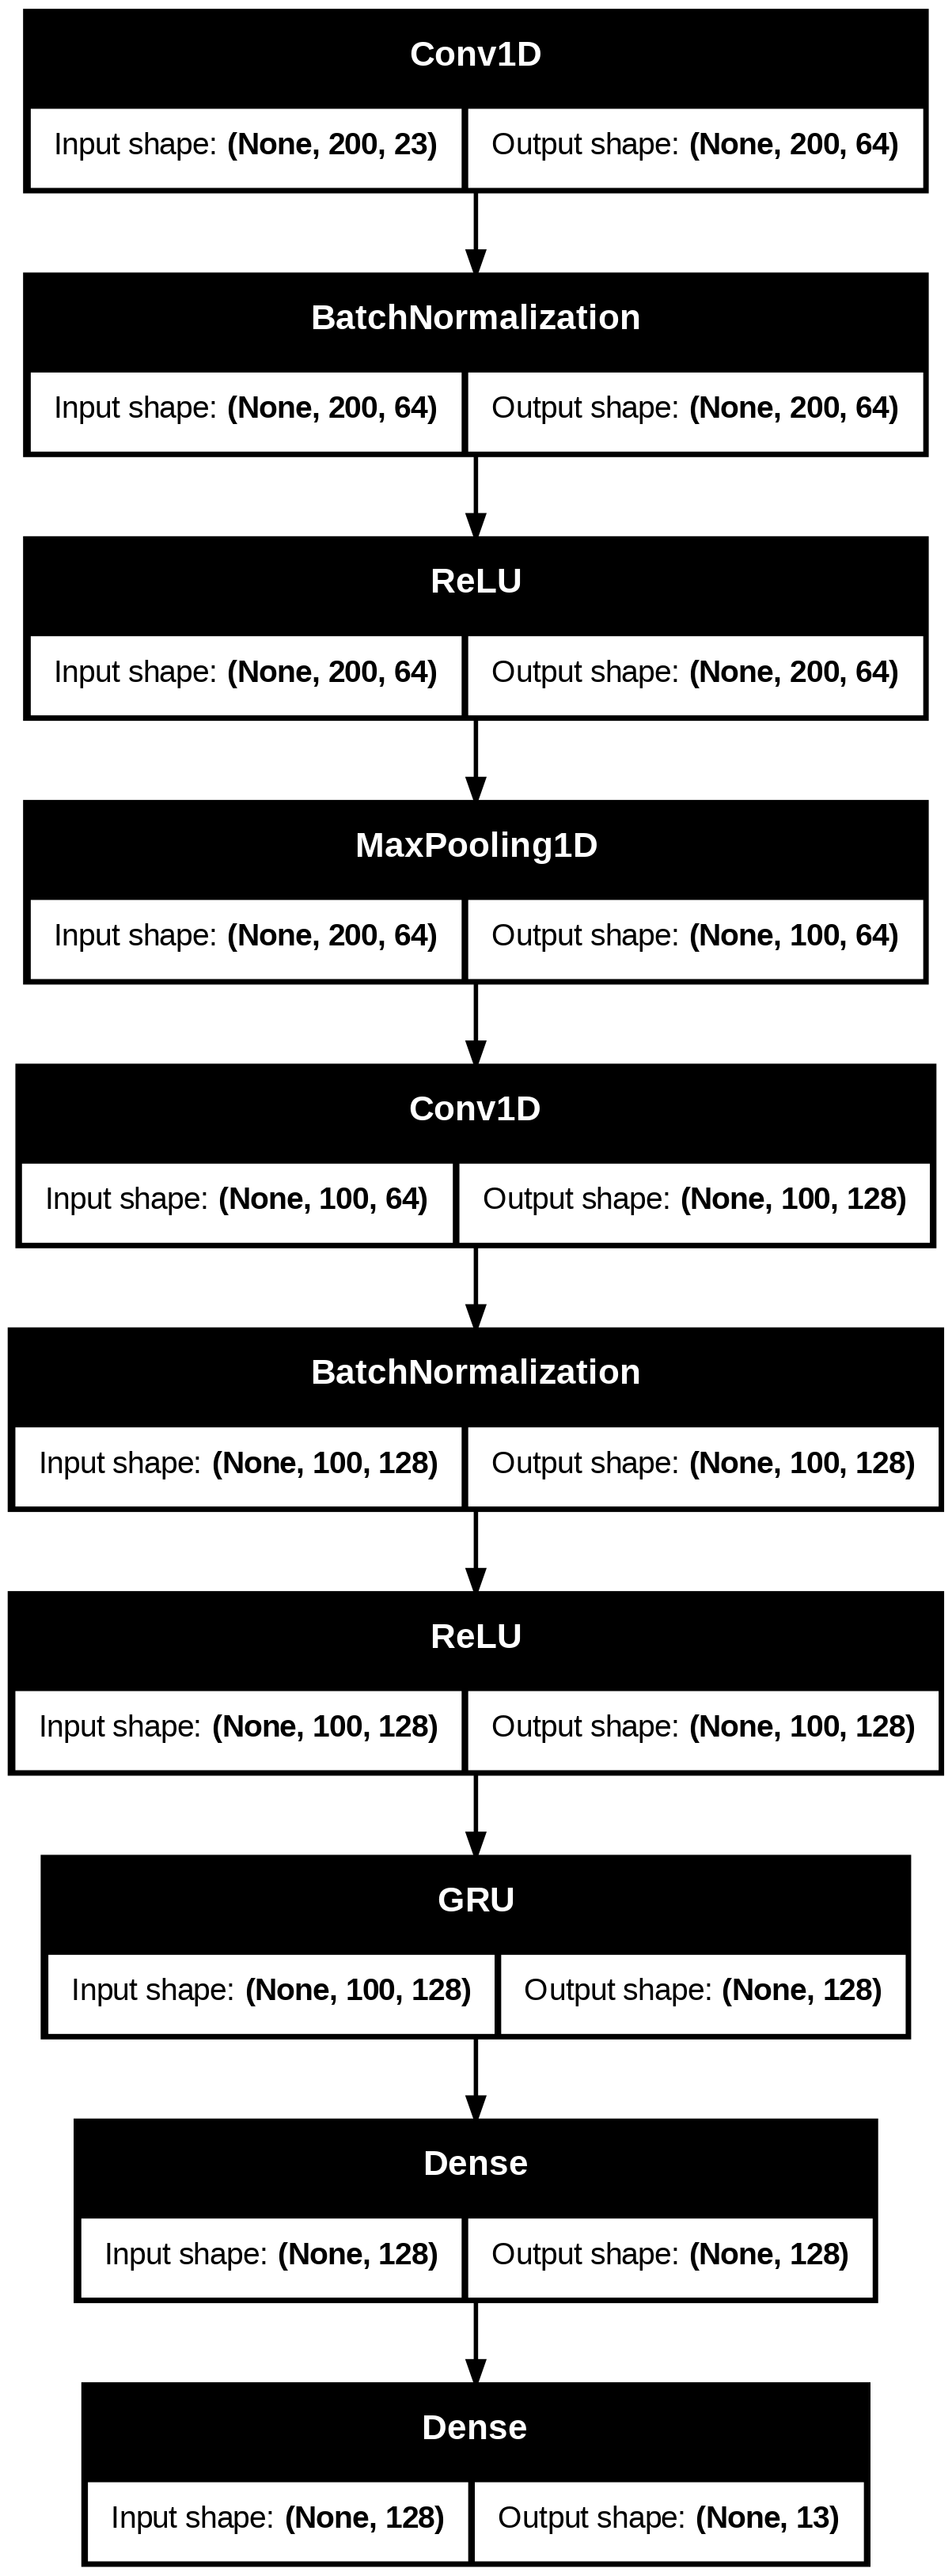

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
callbacks = [
            ModelCheckpoint(
                "mhealth_CNN_GRU_best.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [22]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1432 - sparse_categorical_accuracy: 0.6546
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.88081, saving model to mhealth_CNN_GRU_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.1399 - sparse_categorical_accuracy: 0.6556 - val_loss: 0.4145 - val_sparse_categorical_accuracy: 0.8808
Epoch 2/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0925 - sparse_categorical_accuracy: 0.9709
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.88081
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9711 - val_loss: 0.4953 - val_sparse_categorical_accuracy: 0.8573
Epoch 3/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9876
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.88081
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.6845 - val_sparse_categorical_accuracy: 0.8393
Epoch 4/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0371 - sparse_categorical_accuracy: 0.9870
Epoch 4: val_sparse_categorical_accuracy improved from 0.88081 to 0.89940

177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0371 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.3534 - val_sparse_categorical_accuracy: 0.8994
Epoch 5/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233 - sparse_categorical_accuracy: 0.9931
Epoch 5: val_sparse_categorical_accuracy improved from 0.89940 to 0.90268, saving model to mhealth_CNN_GRU_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0233 - sparse_categorical_accuracy: 0.9931 - val_loss: 0.3429 - val_sparse_categorical_accuracy: 0.9027
Epoch 6/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9894
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.90268
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9894 - val_loss: 1.0212 - val_sparse_categorical_accuracy: 0.8125
Epoch 7/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9926
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.90268
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.3754 - val_sparse_categorical_accuracy: 0.8874
Epoch 8/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9930
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.90268
17

177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0107 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.3442 - val_sparse_categorical_accuracy: 0.9174
Epoch 12/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - sparse_categorical_accuracy: 0.9934
Epoch 12: val_sparse_categorical_accuracy did not improve from 0.91744
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0174 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.2184 - val_sparse_categorical_accuracy: 0.9060
Epoch 13/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9921
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.91744
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.5503 - val_sparse_categorical_accuracy: 0.9125
Epoch 14/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165 - sparse_categorical_accuracy: 0.9931
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.9

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0157 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.1233 - val_sparse_categorical_accuracy: 0.9645
Epoch 26/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0089 - sparse_categorical_accuracy: 0.9969
Epoch 26: val_sparse_categorical_accuracy did not improve from 0.96446
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0089 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.2322 - val_sparse_categorical_accuracy: 0.9377
Epoch 27/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9971
Epoch 27: val_sparse_categorical_accuracy did not improve from 0.96446
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0066 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.2113 - val_sparse_categorical_accuracy: 0.9229
Epoch 28/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9975
Epoch 28: val_sparse_categorical_accuracy did not improve from 0.9

177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0386 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.0829 - val_sparse_categorical_accuracy: 0.9814
Epoch 44/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9969
Epoch 44: val_sparse_categorical_accuracy did not improve from 0.98141
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.2085 - val_sparse_categorical_accuracy: 0.9213
Epoch 45/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0183 - sparse_categorical_accuracy: 0.9947
Epoch 45: val_sparse_categorical_accuracy did not improve from 0.98141
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0182 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.4392 - val_sparse_categorical_accuracy: 0.8863
Epoch 46/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - sparse_categorical_accuracy: 0.9977
Epoch 46: val_sparse_categorical_accuracy did not improve from 0.9

In [23]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_CNN_GRU_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 99.84%
Training loss: 0.0047
Validation accuracy: 98.14%
Validation loss: 0.0829


In [24]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       140
           1     0.9935    1.0000    0.9968       154
           2     1.0000    1.0000    1.0000       154
           3     1.0000    0.9935    0.9967       153
           4     0.9935    0.9935    0.9935       154
           5     0.9745    0.9935    0.9839       154
           6     1.0000    1.0000    1.0000       133
           7     1.0000    0.9787    0.9892       141
           8     0.9928    0.9384    0.9648       146
           9     0.9444    1.0000    0.9714       153
          10     0.9448    1.0000    0.9716       154
          11     1.0000    0.9351    0.9664       154
          12     1.0000    1.0000    1.0000        49

    accuracy                         0.9864      1839
   macro avg     0.9880    0.9871    0.9873      1839
weighted avg     0.9870    0.9864    0.9864      1839



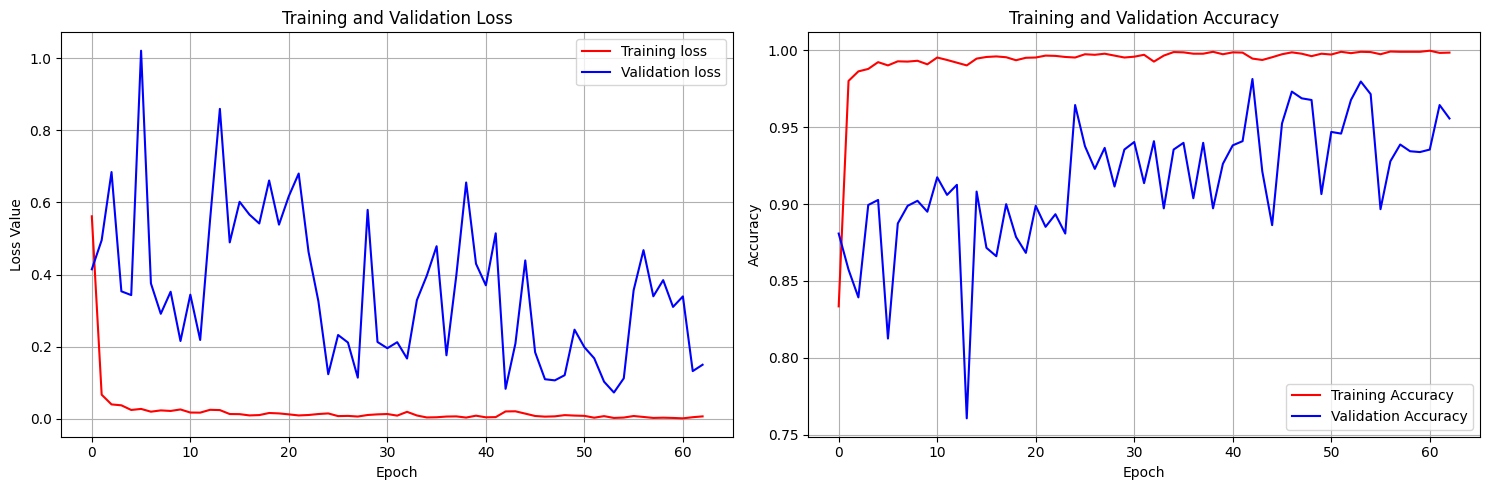

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

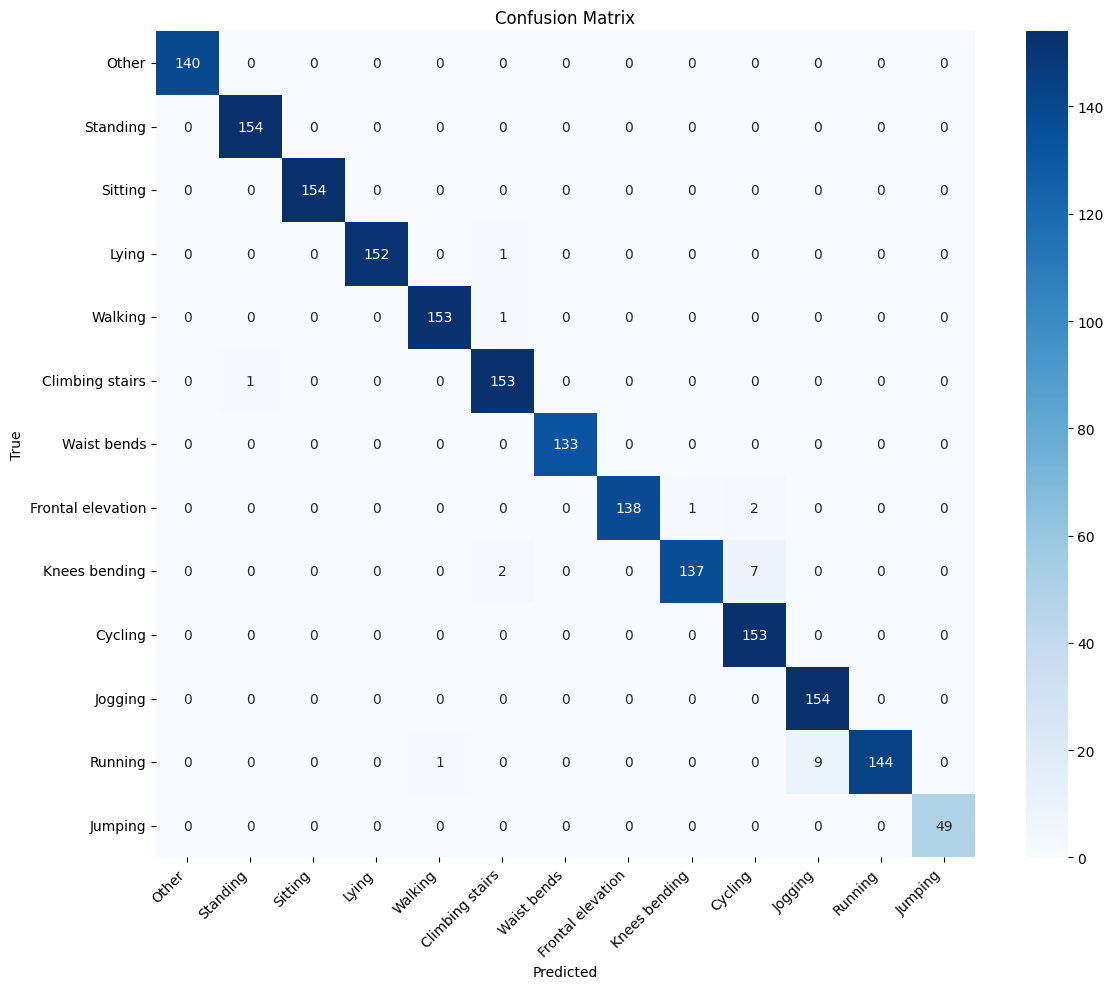

In [27]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 2, GRU 2

In [29]:
input_shape = (200, 23)
num_classes = 13

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=128, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())

model.add(GRU(128, return_sequences=True))
model.add(GRU(128, return_sequences=False))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 200, 64)        │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 100, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 100, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,285 (962.05 KB)

 Trainable params: 245,901 (960.55 KB)

 Non-trainable params: 384 (1.50 KB)

None


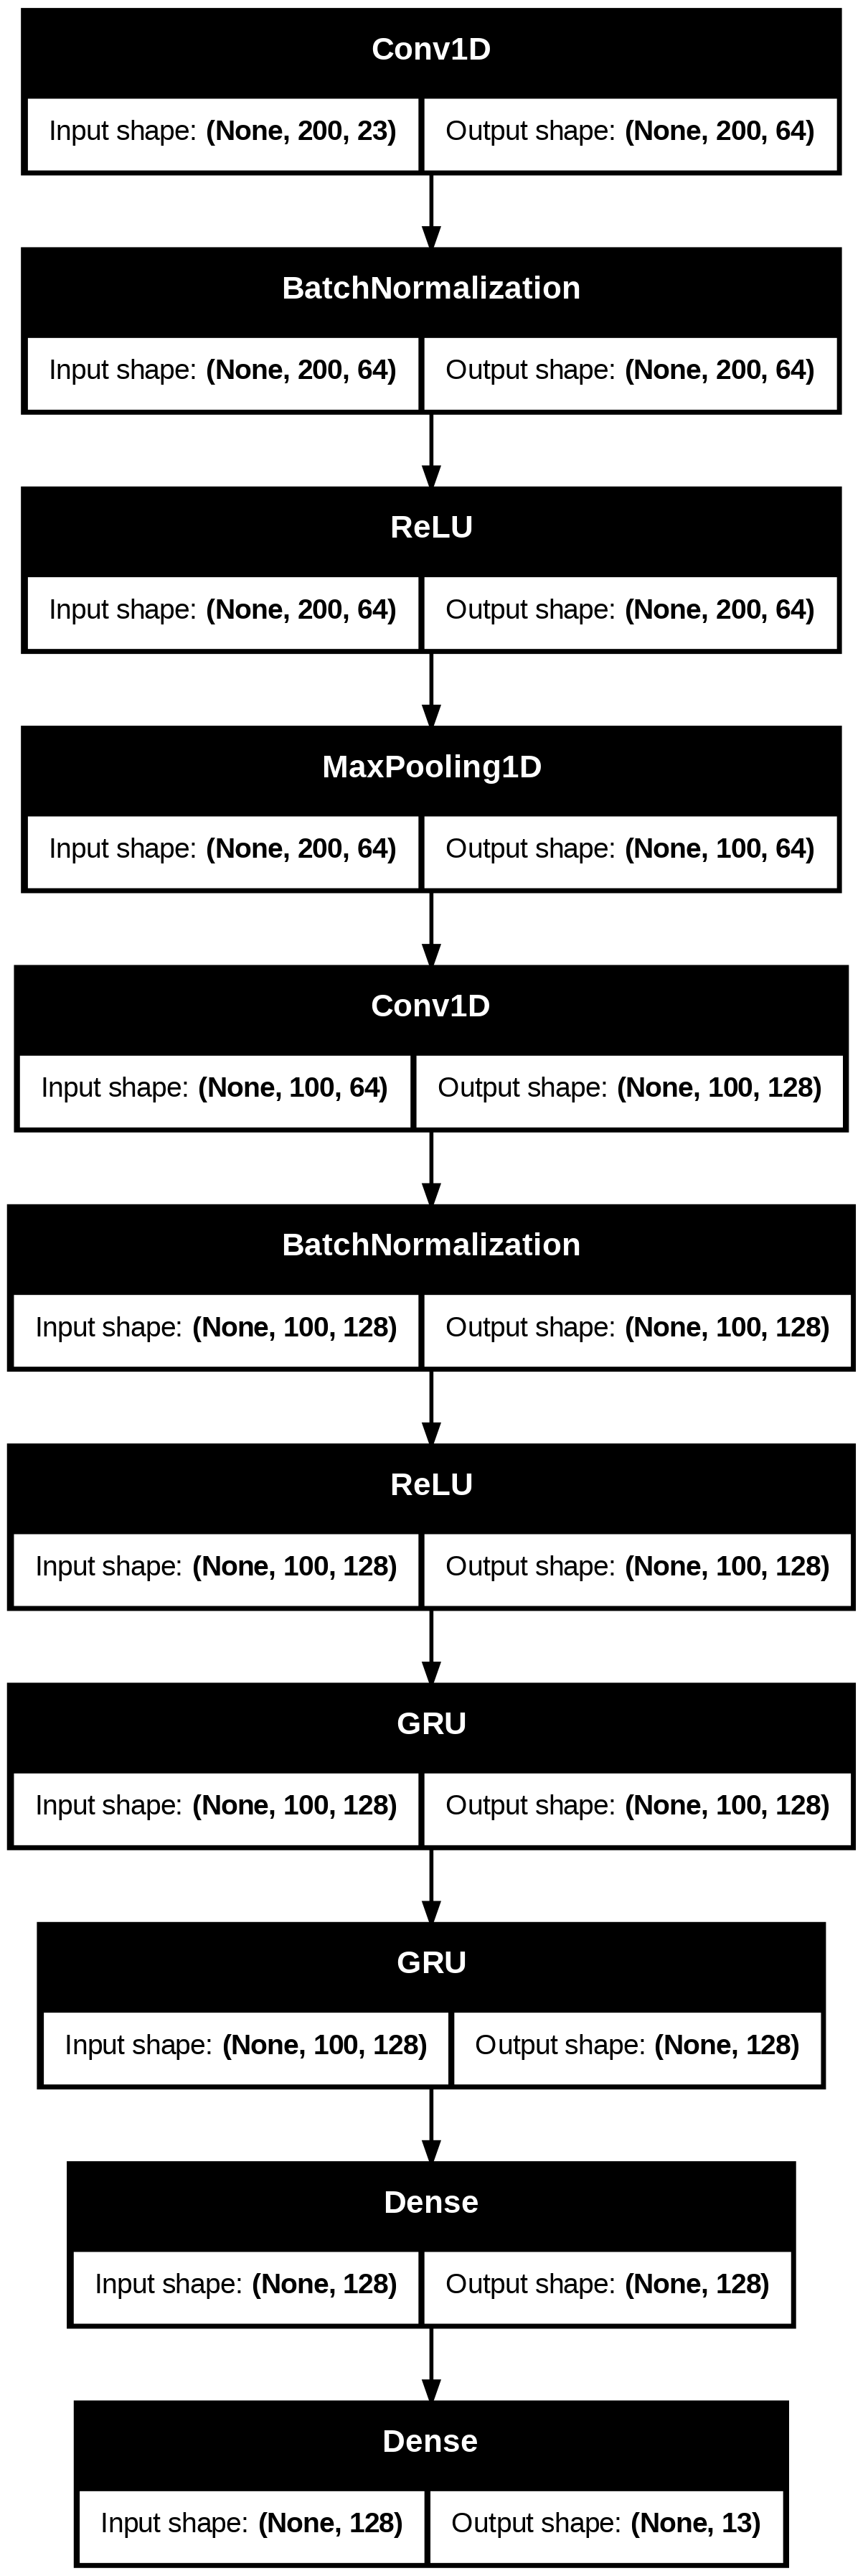

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:
callbacks = [
            ModelCheckpoint(
                "mhealth_CNN_GRU_best2.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [32]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0741 - sparse_categorical_accuracy: 0.6722
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.82941, saving model to mhealth_CNN_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.0615 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.5734 - val_sparse_categorical_accuracy: 0.8294
Epoch 2/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9826
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.82941
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0594 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.8205 - val_sparse_categorical_accuracy: 0.7633
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9835
Epoch 3: val_sparse_categorical_accuracy improved from 0.82941 to 0.89338, saving model to mhealth_CNN_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.3648 - val_sparse_categorical_accuracy: 0.8934
Epoch 4/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0394 - sparse_categorical_accuracy: 0.9862
Epoch 4: val_sparse_categorical_accuracy improved from 0.89338 to 0.93822, saving model to mhealth_CNN_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0394 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.2580 - val_sparse_categorical_accuracy: 0.9382
Epoch 5/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9896
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.93822
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0364 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.3082 - val_sparse_categorical_accuracy: 0.9109
Epoch 6/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9916
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.93822
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.5040 - val_sparse_categorical_accuracy: 0.8617
Epoch 7/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0195 - sparse_categorical_accuracy: 0.9928
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.93822
1

177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0183 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.0659 - val_sparse_categorical_accuracy: 0.9798
Epoch 13/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9951
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.97977
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0841 - val_sparse_categorical_accuracy: 0.9798
Epoch 14/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0184 - sparse_categorical_accuracy: 0.9930
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.97977
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.2213 - val_sparse_categorical_accuracy: 0.9437
Epoch 15/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9922
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.9

In [33]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_CNN_GRU_best2.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 99.52%
Training loss: 0.0129
Validation accuracy: 97.98%
Validation loss: 0.0659


In [34]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9871    0.9935    0.9903       154
           2     0.9620    0.4935    0.6524       154
           3     1.0000    1.0000    1.0000       153
           4     1.0000    0.9805    0.9902       154
           5     0.9747    1.0000    0.9872       154
           6     1.0000    1.0000    1.0000       133
           7     0.6385    0.9645    0.7684       141
           8     0.9863    0.9863    0.9863       146
           9     0.9745    1.0000    0.9871       153
          10     1.0000    0.9870    0.9935       154
          11     1.0000    0.9870    0.9935       154
          12     0.9608    1.0000    0.9800        49

    accuracy                         0.9489      1839
   macro avg     0.9603    0.9527    0.9481      1839
weighted avg     0.9617    0.9489    0.9464      1839



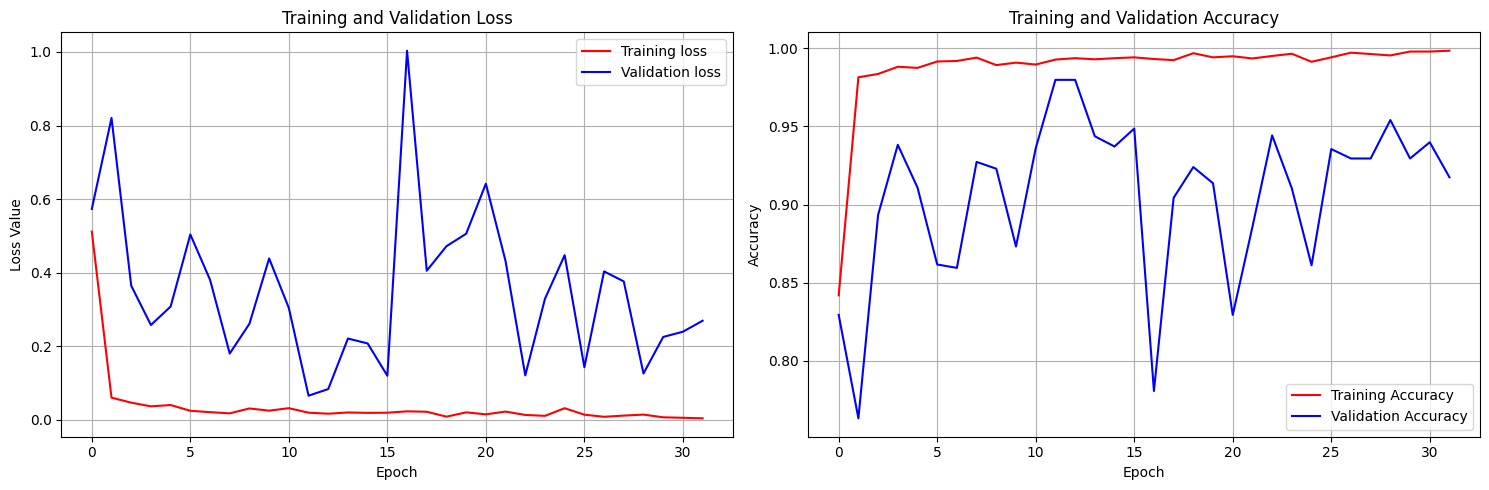

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

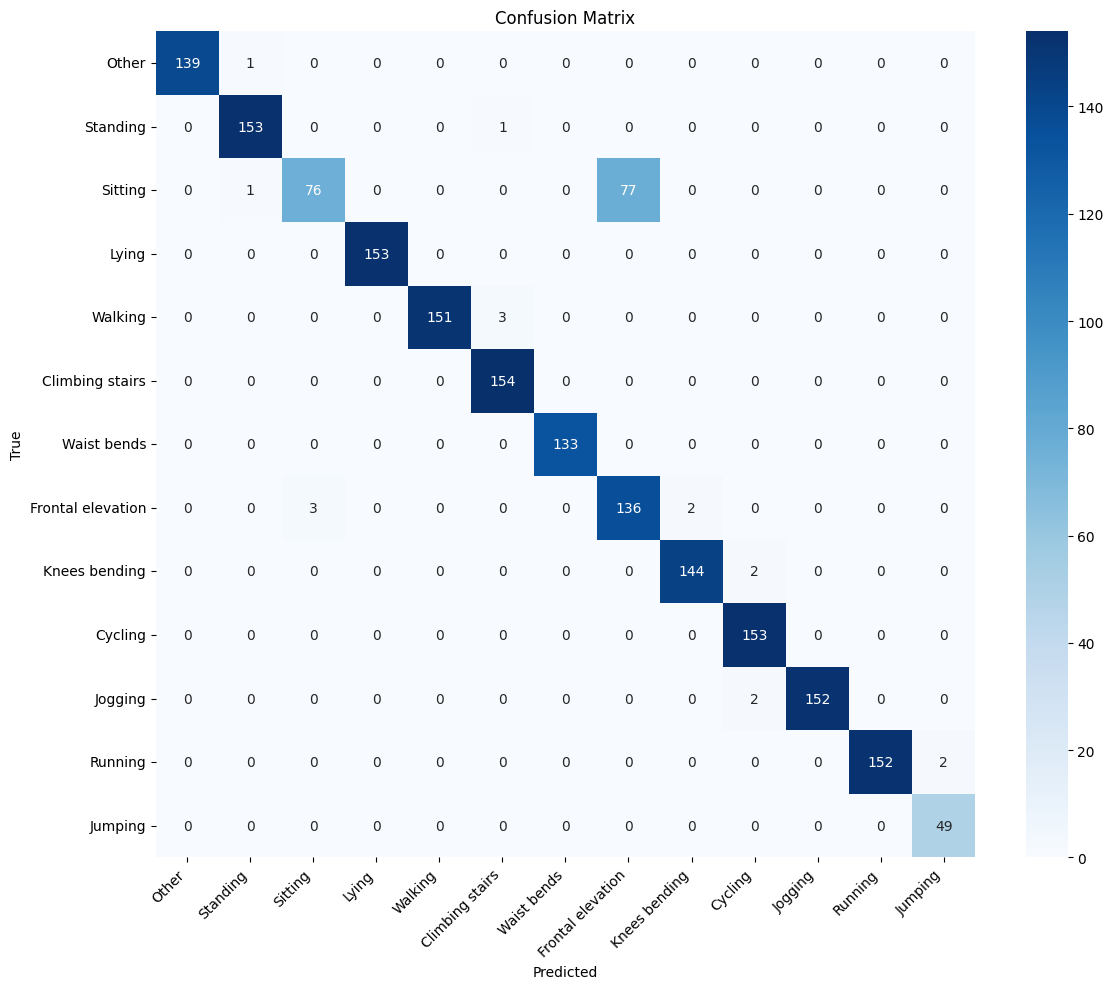

In [36]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()